In [55]:
import numpy as np
from scipy.linalg import eigh_tridiagonal

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsmath}',
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']
})

import sympy as sp
from scipy.optimize import bisect
from scipy.special import hermite

In [2]:
def get_H(x0,x1,n,V):
    x = np.linspace(x0,x1,n)
    h = x[1] - x[0]
    
    T_ = -(np.diag(np.full(n-3,1),k=-1) + np.diag(np.full(n-2,-2),k=0) + np.diag(np.full(n-3,1),k=1))/h**2
    V_ = np.diag(V(x[1:-1]))
    H  = T_ + V_
    
    return x,H

In [211]:
def solve_SE(x0,x1,n,V):
    x = np.linspace(x0,x1,n)
    h = x[1] - x[0]
    
    d = -np.full(n-2,-2)/h**2 + V(x[1:-1])
    e = -np.full(n-3,1)/h**2
    
    E,psi = eigh_tridiagonal(d,e)
    psi   = np.vstack(([np.zeros(E.shape[0]),psi,np.zeros(E.shape[0])]))
    return x,E,psi.T

# Finite square well

### analytic stuff

In [293]:
A,B,C,D      = sp.symbols(r'A B C D')
k,kappa,V0,a = sp.symbols(r'k \kappa V_0 a',real=True,positive=True)
u            = sp.Symbol(r'u')

psi1 = A*sp.exp(kappa*u)
psi2 = B*sp.cos(k*u) + C*sp.sin(k*u)
psi3 = D*sp.exp(-kappa*u)

BC1 = sp.Eq(psi1.subs(u,-1)        ,psi2.subs(u,-1))
BC2 = sp.Eq(psi1.diff(u).subs(u,-1),psi2.diff(u).subs(u,-1))
BC3 = sp.Eq(psi2.subs(u,1)         ,psi3.subs(u,1))
BC4 = sp.Eq(psi2.diff(u).subs(u,1) ,psi3.diff(u).subs(u,1))

display(BC1)
display(BC2)
display(BC3)
display(BC4)

Eq(A*exp(-\kappa), B*cos(k) - C*sin(k))

Eq(A*\kappa*exp(-\kappa), B*k*sin(k) + C*k*cos(k))

Eq(B*cos(k) + C*sin(k), D*exp(-\kappa))

Eq(-B*k*sin(k) + C*k*cos(k), -D*\kappa*exp(-\kappa))

In [294]:
A_ = sp.solve(BC1,A,dict=True)[0][A]
D_ = sp.solve(BC3,D,dict=True)[0][D]

display(sp.Eq(A,A_))
display(sp.Eq(D,D_))

BC2 = BC2.subs(A,A_).simplify()
BC4 = BC4.subs(D,D_).simplify()

display(BC2.expand())
display(BC4.expand())

Eq(A, (B*cos(k) - C*sin(k))*exp(\kappa))

Eq(D, (B*cos(k) + C*sin(k))*exp(\kappa))

Eq(B*k*sin(k) + C*k*cos(k), B*\kappa*cos(k) - C*\kappa*sin(k))

Eq(B*\kappa*cos(k) + C*\kappa*sin(k), B*k*sin(k) - C*k*cos(k))

In [295]:
norm = sp.integrate(psi1**2,(u,-sp.oo,-1)) + sp.integrate(psi2**2,(u,-1,1)) + sp.integrate(psi3**2,(u,1,sp.oo))
norm.subs(A,A_).subs(D,D_).simplify().subs(B,0).simplify()

C**2*(\kappa*k - \kappa*sin(2*k)/2 + k*sin(k)**2)/(\kappa*k)

In [388]:
def get_finite_well_E(V0):
    f1 = lambda t: t*np.tan(t) - np.sqrt(V0 - t**2)
    f2 = lambda t: t/np.tan(t) + np.sqrt(V0 - t**2)
    
    k     = []
    ab    = np.array([1e-5,(1-1e-5)*np.pi/2])
    k_max = np.sqrt(V0)
    N     = np.ceil(2*k_max/np.pi).astype(int)
    for i in range(N):
        if ab[-1] > k_max:
            ab[-1] = (1-1e-16)*k_max
        
        f = f1 if i%2==0 else f2
        k.append(bisect(f,*ab))
        
        ab += np.pi/2
        
    E = np.array(k)**2
    return E

In [389]:
def get_finite_well_psi(u,V0):
    temp = get_finite_well_E(V0)
    k    = np.sqrt(temp)
    U,K  = np.meshgrid(u,k)
    
    kappa = np.sqrt(V0 - K**2)
    n     = np.arange(temp.shape[0])
    
    B = 1/np.sqrt(1 + np.sin(2*K)/2/K + np.cos(K)**2/kappa)
    B[n%2==1] = 0
    C = 1/np.sqrt(1 - np.sin(2*K)/2/K + np.sin(K)**2/kappa)
    C[n%2==0] = 0
    
    A = (B*np.cos(K) - C*np.sin(K))*np.exp(kappa)
    D = (B*np.cos(K) + C*np.sin(K))*np.exp(kappa)
    
    return temp,A*np.exp(kappa*U)*(U<-1) + (B*np.cos(K*U) + C*np.sin(K*U))*(np.abs(U) < 1) + D*np.exp(-kappa*U)*(U>1)

In [392]:
V0 = 10
E_  = get_finite_well_E(V0)
# k_  = np.sqrt(E)
# kappa_ = np.sqrt(V0 - E)

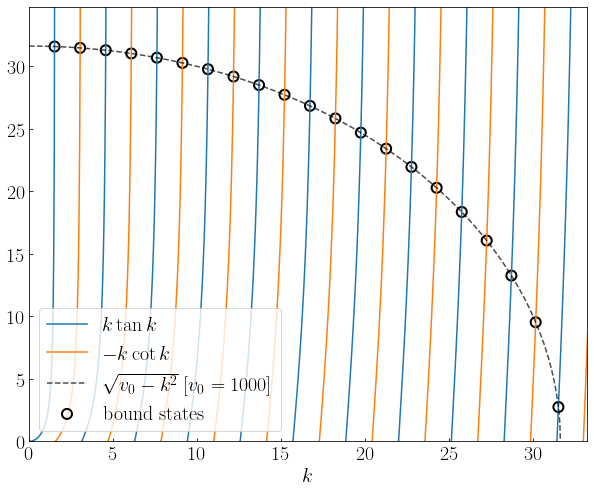

In [393]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,8*nrows))

v0 = 1000
N  = np.ceil(np.pi*np.sqrt(v0)/np.pi).astype(int)
for i in range(0,N):
    k = np.linspace(1e-10+i*np.pi/2,(i+1)*np.pi/2-1e-10)
    ax.plot(k,k*np.tan(k),'C0',label=r'$k \tan{k}$' if i==0 else '')
    ax.plot(k,-k/np.tan(k),'C1',label=r'$-k \cot{k}$' if i==0 else '')

k = np.linspace(1e-3,np.sqrt(v0),1000)
ax.plot(k,np.sqrt(v0-k**2),'k--',alpha=0.7,label=r'$\sqrt{v_0 - k^2}~[v_0 = %d]$'%v0)

E_  = get_finite_well_E(v0)
k_  = np.sqrt(E_)
n_  = np.arange(k_.shape[0])
lhs = k_*(np.tan(k_)*(n_%2==0) - 1/np.tan(k_)*(n_%2==1))
ax.scatter(k_,lhs,color='None',marker='o',edgecolor='k',s=100,lw=2,label=r'$\rm bound~states$')

ax.set_xlim(0,1.05*np.sqrt(v0))
ax.set_ylim(0,1.1*np.sqrt(v0))
ax.tick_params(axis='both',which='major',direction='in',labelsize=20)
ax.set_xlabel(r'$k$',size=20)
ax.legend(fontsize=20,loc='lower left',frameon=True)

plt.show()
fig.savefig(r'finite_well_exact_solutions.pdf',bbox_inches='tight')

### numerical stuff

-- to do: comparison with analytic solutions (transcendental equation for even/odd solutions, how many solutions exist)

In [394]:
def V(t,V0=1):
    temp = V0*(np.abs(t) > 1).astype(float)
    return temp

In [395]:
V0 = 15
x,E,psi = solve_SE(-10,10,201,lambda t: V(t,V0=V0))
h   = x[1] - x[0]

E[:10]

array([ 1.42113865,  5.54755706, 11.75390743, 15.1137664 , 15.12810827,
       15.45231523, 15.50982072, 16.00720438, 16.13865404, 16.76444784])

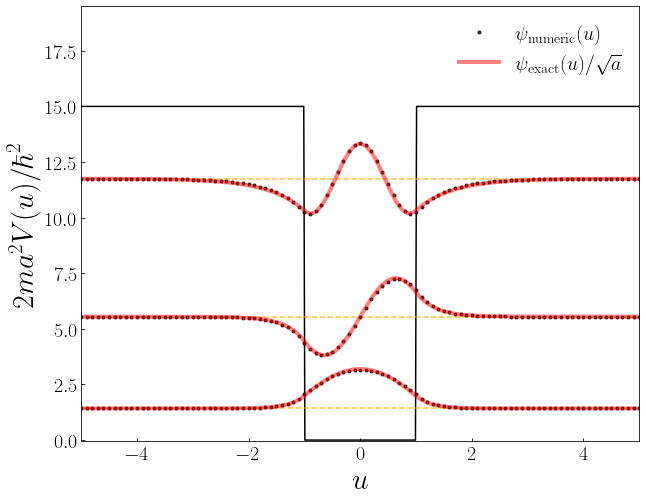

In [400]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,8*nrows))

x_ = np.linspace(-10,10,1000)
ax.plot(x_,V(x_,V0=V0),color='k',alpha=1)

E_,psi_ = get_finite_well_psi(x_,V0)

scale = 2
for i in range(len(E[E<V0])):
    sign = np.sign(psi[i][1])/np.sign(psi_[i][1])
    
    ax.axhline(E[i],color='orange',ls='--',alpha=0.7)
    ax.plot(x,scale*sign*psi[i]/np.sqrt(h) + E[i],'k.',alpha=0.8,label=r'$\psi_{\rm numeric}(u)$' if i==0 else '')
    ax.plot(x_,scale*psi_[i]+E[i],'r-',lw=4,alpha=0.5,label=r'$\psi_{\rm exact}(u)/\sqrt{a}$' if i==0 else '')

ax.set_xlim(-5,5)
ax.set_ylim(-0.05,1.3*V0)
ax.set_xlabel(r'$u$',size=30)
ax.set_ylabel(r'$2 m a^2 V(u) / \hbar^2$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')
ax.legend(fontsize=20,loc='upper right',frameon=False)

plt.show()

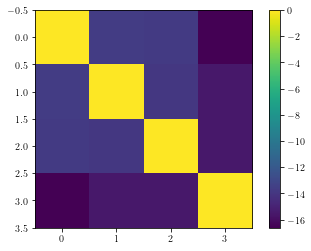

In [401]:
img = plt.imshow(np.log10(np.abs(psi[:4]@psi[:4].T)),cmap='viridis')
plt.colorbar(img)
plt.show()

# Harmonic oscillator

In [418]:
def V(t):
    return t**2

In [419]:
def get_HO_psi(u,n):
    Hn = hermite(n)
    return np.pi**(-0.25)/np.sqrt(2**n*np.math.factorial(n))*Hn(u)*np.exp(-u**2/2)

In [420]:
x,E,psi = solve_SE(-50,50,1000,V)
h   = x[1] - x[0]

In [421]:
E[:10]

array([ 0.99937336,  2.9968652 ,  4.99184494,  6.9843078 ,  8.974249  ,
       10.9616637 , 12.94654704, 14.92889415, 16.90870009, 18.88595991])

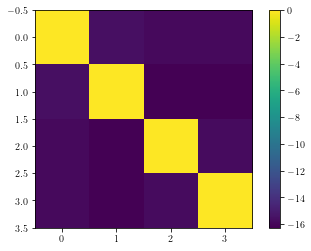

In [422]:
img = plt.imshow(np.log10(np.abs(psi[:4]@psi[:4].T)),cmap='viridis')
plt.colorbar(img)

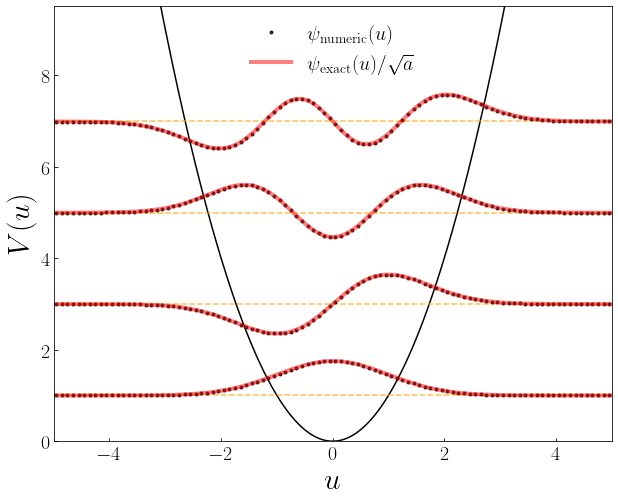

In [438]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,8*nrows))

x_ = np.linspace(-5,5,1000)
ax.plot(x_,V(x_),color='k',alpha=1)

n    = 4
psi_ = np.array([get_HO_psi(x_,_) for _ in range(n)])

scale = 1
for i in range(n):
    sign = np.sign(psi[i][1])#/np.sign(psi_[i][1])
    
    ax.axhline(E[i],color='orange',ls='--',alpha=0.7)
    ax.plot(x,scale*psi[i]/np.sqrt(h) + E[i],'k.',alpha=0.8,label=r'$\psi_{\rm numeric}(u)$' if i==0 else '')
    ax.plot(x_,scale*psi_[i]+E[i],'r-',lw=4,alpha=0.5,label=r'$\psi_{\rm exact}(u)/\sqrt{a}$' if i==0 else '')

ax.set_xlim(-5,5)
ax.set_ylim(0,9.5)
ax.set_xlabel(r'$u$',size=30)
ax.set_ylabel(r'$V(u)$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')
ax.legend(fontsize=20,loc='upper center',frameon=False)

plt.show()

# Morse Potential

In [439]:
def V(t,D=20,x0=1):
    return D*(1-np.exp(-(t-x0)))**2

In [440]:
x,E,psi = solve_SE(0,3,100,V)

In [441]:
E[:10]

array([  4.23232432,  11.35634483,  18.08256999,  26.43060554,
        36.79898627,  49.14932489,  63.50300456,  79.89986319,
        98.36597569, 118.90866523])

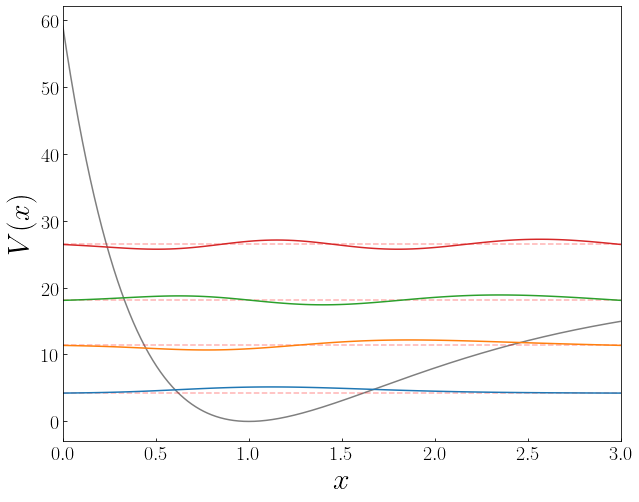

In [442]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,8*nrows))

x_ = np.linspace(0,3,1000)
ax.plot(x_,V(x_),color='k',alpha=0.5)


for i in range(4):
    ax.axhline(E[i],color='r',ls='--',alpha=0.3)
    ax.plot(x,5*psi[i] + E[i])

ax.set_xlim(0,3)
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$V(x)$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')

plt.show()

In [ ]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

ax.plot(x,psi[0])
ax.plot(x,psi[1])
ax.plot(x,psi[2])
# ax.plot(x,psi[3])
# ax.plot(x,psi[4])

plt.show()

# Hydrogen atom - radial equation

In [443]:
def V(t,l=0):
    return l*(l+1)/t**2 - 2/t

In [488]:
l = 0
x,E,u = solve_SE(0,100,1000,lambda t: V(t,l))
h = x[1]-x[0]

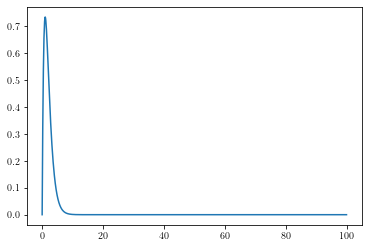

In [489]:
plt.plot(x,u[0]/np.sqrt(h))
plt.show()

In [ ]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,8*nrows))

x_ = np.linspace(-5,5,1000)
ax.plot(x_,V(x_),color='k',alpha=1)

# n    = 4
# psi_ = np.array([get_HO_psi(x_,_) for _ in range(n)])

scale = 1
for i in range(n):
    sign = np.sign(psi[i][1])#/np.sign(psi_[i][1])
    
    ax.axhline(E[i],color='orange',ls='--',alpha=0.7)
    ax.plot(x,scale*psi[i]/np.sqrt(h) + E[i],'k.',alpha=0.8,label=r'$\psi_{\rm numeric}(u)$' if i==0 else '')
    ax.plot(x_,scale*psi_[i]+E[i],'r-',lw=4,alpha=0.5,label=r'$\psi_{\rm exact}(u)/\sqrt{a}$' if i==0 else '')

ax.set_xlim(-5,5)
ax.set_ylim(0,9.5)
ax.set_xlabel(r'$u$',size=30)
ax.set_ylabel(r'$V(u)$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')
ax.legend(fontsize=20,loc='upper center',frameon=False)

plt.show()